# Exploratory Data Analysis of Acceleration-Behavior Data

**Author**: Medha Agarwal

**Last modified**: June 11, 2024

In this notebook, we conduct explorations on the accceleration data, available behavior annotations, and matched acceleration-behavior pairs. 

In [1]:
import os
import sys
import ast
import time
sys.path.append('.')
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.io import (get_matched_data_path,
                          get_matched_metadata_path,
                          get_matched_summary_path,
                          get_figures_dir)

from src.utils.plot import plot_raw_time_series

from src.utils.data import (create_data_tensors,
                            adjust_behavior_and_durations,
                            create_data_tensors,
                            create_matched_data)
                            
from src.data_prep.data_prep_utils import combined_annotations

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                             BEHAVIORS,
                             SAMPLING_RATE,
                             AWD_VECTRONICS_PATHS,
                             id_mapping,
                             VECTRONICS_METADATA_PATH)

In [2]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

First let us load dataframes for matched acceleration-behavior pairs and their metadata. These objects are created by running `src/data_prep/create_matched_data_objects.py` script. Next we extract fixed length windows from the acceleration data.

In [3]:
acc_data = pd.read_csv(get_matched_data_path())
acc_metadata = pd.read_csv(get_matched_metadata_path())
acc_summary = pd.read_csv(get_matched_summary_path())

In [5]:
all_annotations = combined_annotations(AWD_VECTRONICS_PATHS, id_mapping) # load annotations 
metadata = pd.read_csv(VECTRONICS_METADATA_PATH) # load metadata

start = time.time()
_, df, _ = create_matched_data(metadata, all_annotations)
lag = time.time() - start
print(f'Total time - {lag:.2f}, average time - {(lag/len(df))}')

Dog jessie has 506 halfdays in the filtered metadata.


Processing unique half days for jessie: 100%|██████████| 506/506 [00:49<00:00, 10.25it/s]


Dog green has 900 halfdays in the filtered metadata.


Processing unique half days for green: 100%|██████████| 900/900 [00:38<00:00, 23.30it/s]


Dog palus has 744 halfdays in the filtered metadata.


Processing unique half days for palus: 100%|██████████| 744/744 [00:04<00:00, 171.56it/s] 


Dog ash has 792 halfdays in the filtered metadata.


Processing unique half days for ash: 100%|██████████| 792/792 [00:37<00:00, 21.40it/s]


Dog fossey has 448 halfdays in the filtered metadata.


Processing unique half days for fossey: 100%|██████████| 448/448 [00:19<00:00, 23.35it/s]

Total time - 148.69, average time - 0.014647876907482416


In [4]:
acc_data = adjust_behavior_and_durations(acc_data, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS)
print(np.percentile(acc_data['duration'].values, 50))

12.937


In [5]:
X, y, z = create_data_tensors(acc_data, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS, SAMPLING_RATE, 
                        padding='repeat', reuse_behaviors=['Eating', 'Running', 'Moving', 'Resting', 'Vigilant'], min_duration=1.0, duration_percentile=50)

Duration of window is 12.937 sec.


In [6]:
print(X.shape, y.shape, len(z))
temp = z.copy()
temp['behavior'] = y
print(pd.DataFrame(temp.groupby(['Source', 'behavior'])['year'].count()))
print(pd.DataFrame(temp.groupby('dog ID')['year'].count()))

(23031, 3, 206) (23031,) 23031
                  year
Source behavior       
Audio  Feeding      14
       Moving      120
       Running     153
       Vigilant     20
Video  Feeding     138
       Moving      616
       Resting   15442
       Running      32
       Vigilant   6496
        year
dog ID      
ash     4493
fossey  2275
green   6844
jessie  9051
palus    368


In [7]:
print(X.shape, y.shape, len(z))
temp = z.copy()
temp['behavior'] = y
grouped_behaviors = pd.DataFrame(temp.groupby(['Source', 'behavior'])['year'].count()).reset_index()
grouped_behaviors = grouped_behaviors.rename(columns={'year':'count'})
grouped_behaviors['proportion'] = round(100*grouped_behaviors['count']/sum(grouped_behaviors['count']), 3)
print(grouped_behaviors)

(23031, 3, 206) (23031,) 23031
  Source  behavior  count  proportion
0  Audio   Feeding     14       0.061
1  Audio    Moving    120       0.521
2  Audio   Running    153       0.664
3  Audio  Vigilant     20       0.087
4  Video   Feeding    138       0.599
5  Video    Moving    616       2.675
6  Video   Resting  15442      67.049
7  Video   Running     32       0.139
8  Video  Vigilant   6496      28.205


Acceleration data is collected continuously most days, while behavior annotations are sporadically recorded by humans observing animals from a distance. This results in much shorter durations for annotations compared to acceleration data. Consequently, we assess the proportion of annotated behavior duration that can be matched with the available acceleration data.

In [8]:
matched_behavior_durations = pd.DataFrame(acc_summary.groupby('id')['annotations'].sum())
matched_behavior_durations['acc'] = pd.DataFrame(acc_summary.groupby('id')['acc'].sum())['acc']
matched_behavior_durations['acc'] = pd.DataFrame(acc_summary.groupby('id')['acc'].sum())['acc']
print(matched_behavior_durations/3600)

        annotations        acc
id                            
ash       24.785000  24.737102
fossey    10.605556  10.587076
green     29.426111  28.881967
jessie    39.430833  38.987613
palus      1.698333   1.694553


Notice that most of the behavior annotations are matched with acceleration data. Now we collapse some behavioral annotations into coarser classes and pick only the behaviors of interest. We also filter out some unreliable observations. This includes - 1) all behavior annotations less than 1 second, 2) video labels for eating, running, and moving behavior that are less than 8 seconds. 

In [9]:
acc_data = adjust_behavior_and_durations(acc_data, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS)

In [38]:
behavior_EDA = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].sum()/3600)
behavior_EDA = behavior_EDA.rename(columns={'duration': 'total duration [h]'})
behavior_EDA['average duration [s]'] = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].mean())['duration']
behavior_EDA['Min duration [s]'] = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].min())['duration']
behavior_EDA['Max duration [s]'] = pd.DataFrame(acc_data.groupby(['behavior', 'Source'])['duration'].max())['duration']

print(behavior_EDA.sort_values(by='Source').round(3))

                 total duration [h]  average duration [s]  Min duration [s]  \
behavior Source                                                               
Eating   Audio                0.197                50.651             7.937   
Moving   Audio                0.387                43.562             3.937   
Running  Audio                0.482                40.379             3.937   
Vigilant Audio                0.048                11.404             3.937   
Eating   Video                1.318                34.394             8.937   
Moving   Video                1.670                15.221             8.937   
Resting  Video               51.571                85.280             1.937   
Running  Video                0.094                17.726             8.937   
Vigilant Video               16.445                17.022             1.937   

                 Max duration [s]  
behavior Source                    
Eating   Audio            176.937  
Moving   Audio        

In [11]:
dog_EDA = pd.DataFrame(acc_data.groupby('dog ID')['UTC Date [yyyy-mm-dd]'].agg(['min', 'max', 'nunique'])).reset_index()
dog_EDA['duration'] = pd.DataFrame(round(acc_data.groupby('dog ID')['duration'].sum()/3600, 2)).reset_index()['duration']
dog_EDA['total obs'] = pd.DataFrame(acc_data.groupby('dog ID')['duration'].count()).reset_index()['duration']
dog_EDA.columns = ['dog ID', 'start date', 'end date', 'no. of days', 'duration (h)', 'total obs']
print(dog_EDA)

   dog ID  start date    end date  no. of days  duration (h)  total obs
0     ash  2021-10-25  2021-11-13           11         13.71       1436
1  fossey  2022-07-14  2022-07-20            5          6.95        668
2   green  2021-09-03  2021-09-22           13         21.42       1909
3  jessie  2022-08-01  2022-08-16           15         29.04       2177
4   palus  2021-10-27  2021-11-12            2          1.09        121


In [12]:
behavior_durations = pd.DataFrame(round(acc_data.groupby('behavior')['duration'].sum()/3600, 2)).reset_index()
behavior_durations['avg duration (s)'] = pd.DataFrame(acc_data.groupby('behavior')['duration'].mean()).reset_index()['duration']
behavior_durations['total obs'] = pd.DataFrame(acc_data.groupby('behavior')['UTC Date [yyyy-mm-dd]'].count()).reset_index()['UTC Date [yyyy-mm-dd]']
behavior_durations.columns.values[1] = 'total duration (h)'
behavior_durations

,behavior,total duration (h),avg duration (s),total obs
0,Eating,1.52,35.890947,152
1,Moving,2.06,17.344494,427
2,Resting,51.57,85.279930,2177
3,Running,0.58,33.437000,62
4,Vigilant,16.49,16.997729,3493


Notice that most of the available annotations are matched with available acceleration data. Now we extract fixed duration windows from the matched behavior-acceleration dataset using the window size of 12.937 seconds. This is the window size used for training prediction model.

In [13]:
acc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6311 entries, 0 to 10147
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   dog ID                       6311 non-null   object 
 1   behavior                     6311 non-null   object 
 2   behavior_start               6311 non-null   object 
 3   behavior_end                 6311 non-null   object 
 4   duration                     6311 non-null   float64
 5   year                         6311 non-null   int64  
 6   UTC Date [yyyy-mm-dd]        6311 non-null   object 
 7   am/pm                        6311 non-null   object 
 8   half day [yyyy-mm-dd_am/pm]  6311 non-null   object 
 9   avg temperature [C]          6311 non-null   float64
 10  acc_x                        6311 non-null   object 
 11  acc_y                        6311 non-null   object 
 12  acc_z                        6311 non-null   object 
 13  Source                

In [14]:
# Convert stringified lists to actual lists
acc_data['acc_x'] = acc_data['acc_x'].apply(ast.literal_eval)
acc_data['acc_y'] = acc_data['acc_y'].apply(ast.literal_eval)
acc_data['acc_z'] = acc_data['acc_z'].apply(ast.literal_eval)

ValueError: malformed node or string: [0.81, 0.88, 0.88, 0.88, 0.81, 0.81, 0.88, 0.81, 0.81, 0.88, 0.81, 0.88, 0.88, 0.81, 0.81, 0.88, 0.81, 0.88, 0.88, 0.81, 0.88, 0.81, 0.81, 0.81, 0.88, 0.81, 0.88, 0.88, 0.81, 0.88, 0.81, 0.81, 0.81, 0.88, 0.81, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.94, 0.88, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.88, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.88, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.88, 0.88, 0.88, 0.88, 0.94, 0.94, 0.94, 0.88, 0.88, 0.94, 0.94, 0.88, 0.94, 0.94, 0.94, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.94, 0.88, 0.88, 0.88, 0.88, 0.94, 0.88, 0.94, 0.88, 0.94, 0.94, 0.94, 0.94, 0.88, 0.88, 0.94, 0.88, 0.94, 0.88, 0.88, 0.94, 0.94, 0.88, 0.88, 0.88, 0.94, 0.88, 0.94, 0.88, 0.88, 0.88, 0.81, 0.88, 0.63, 0.75, 0.75, 0.75, 0.69, 0.63, 0.63, 0.63, 0.69, 0.69, 0.69, 0.63, 0.56, 0.63, 0.63, 0.56, 0.56, 0.63, 0.56, 0.56, 0.5, 0.56, 0.5, 0.56, 0.56, 0.56, 0.56, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.69, 0.69, 0.69, 0.63, 0.63, 0.69, 0.69, 0.75, 0.75, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.88, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.69, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]

In [ ]:
X, y, z = create_data_tensors(acc_data, 12.937, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS, SAMPLING_RATE)

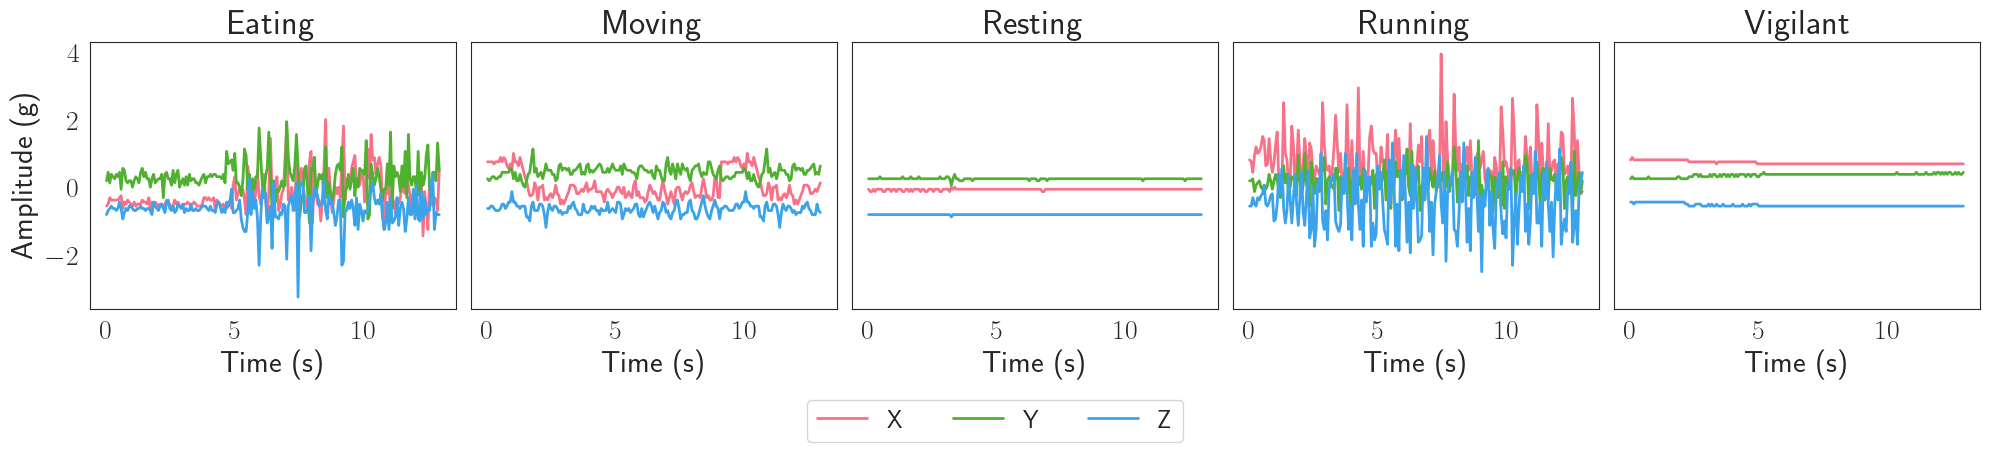

In [15]:
fig_path = os.path.join(get_figures_dir(), 'behaviors_trace.png')
plot_raw_time_series(X, y, save_path=fig_path)

Now let us visualize multiple instances of each behavior to observe key difference in acceleration profile of each behavior.

#### Running

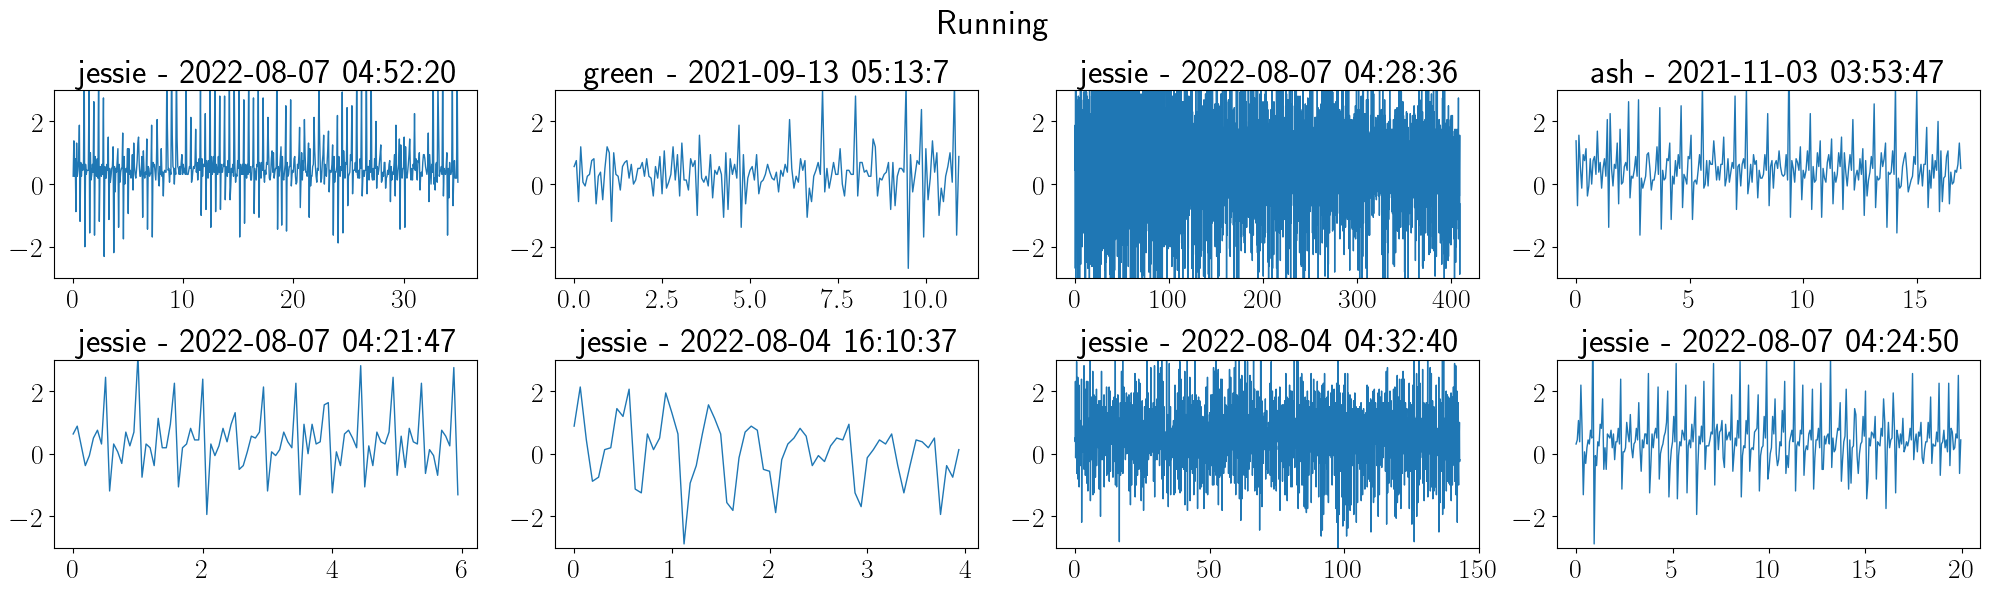

In [81]:
running_data = acc_data[acc_data['behavior'] == 'Running'].reset_index(drop=True)
idx = np.random.choice(range(0, len(running_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(running_data.iloc[idx[i]]['acc_x']))/16, running_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = running_data.iloc[idx[i]]['dog ID'], pd.to_datetime(running_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Running', fontsize=25)
plt.tight_layout()
plt.show()


#### Feeding

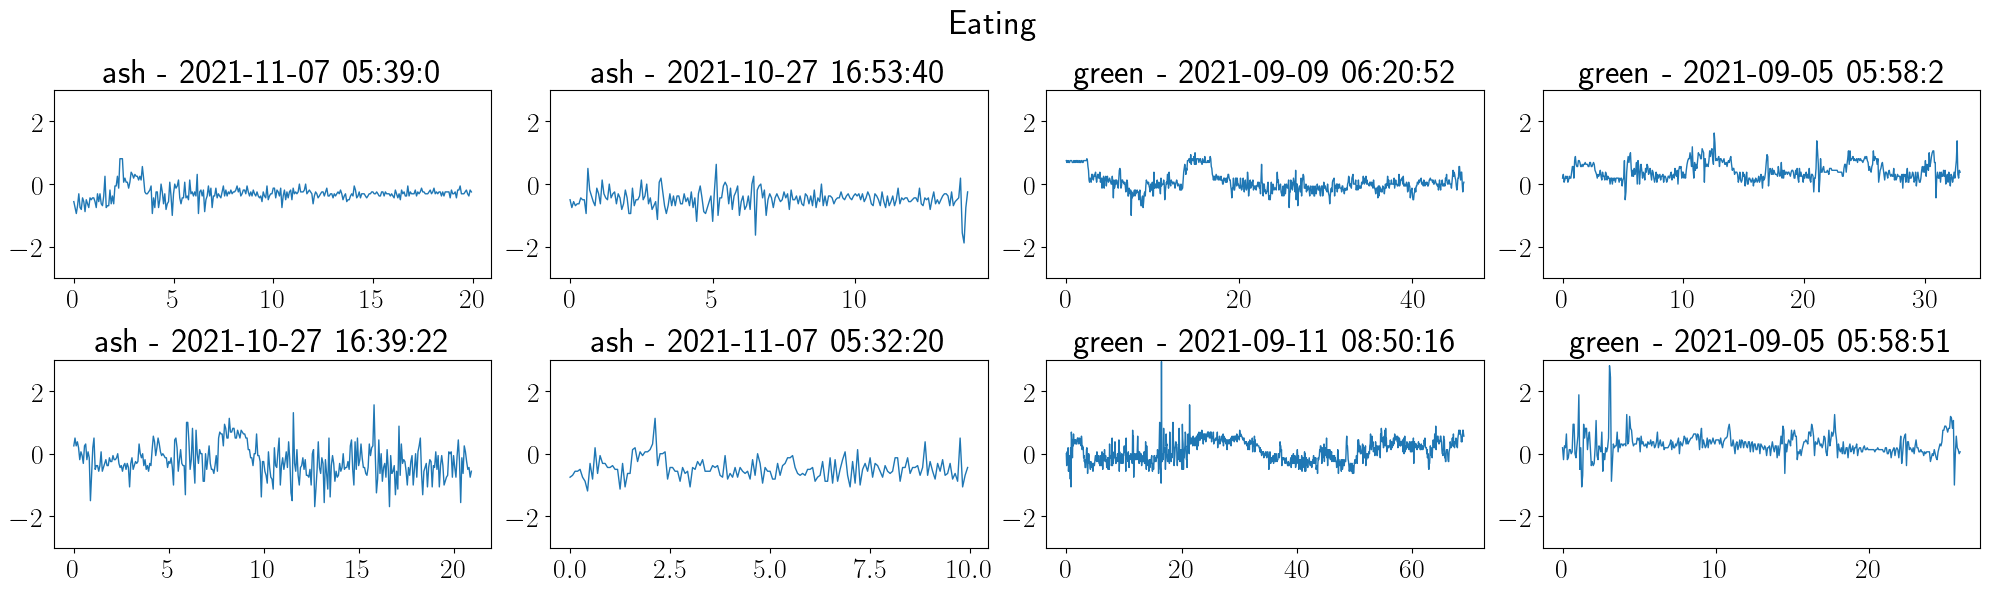

In [84]:
eating_data = acc_data[acc_data['behavior'] == 'Eating'].reset_index(drop=True)
idx = np.random.choice(range(0, len(eating_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(eating_data.iloc[idx[i]]['acc_x']))/16, eating_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = eating_data.iloc[idx[i]]['dog ID'], pd.to_datetime(eating_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Eating', fontsize=25)
plt.tight_layout()
plt.show()


#### Moving

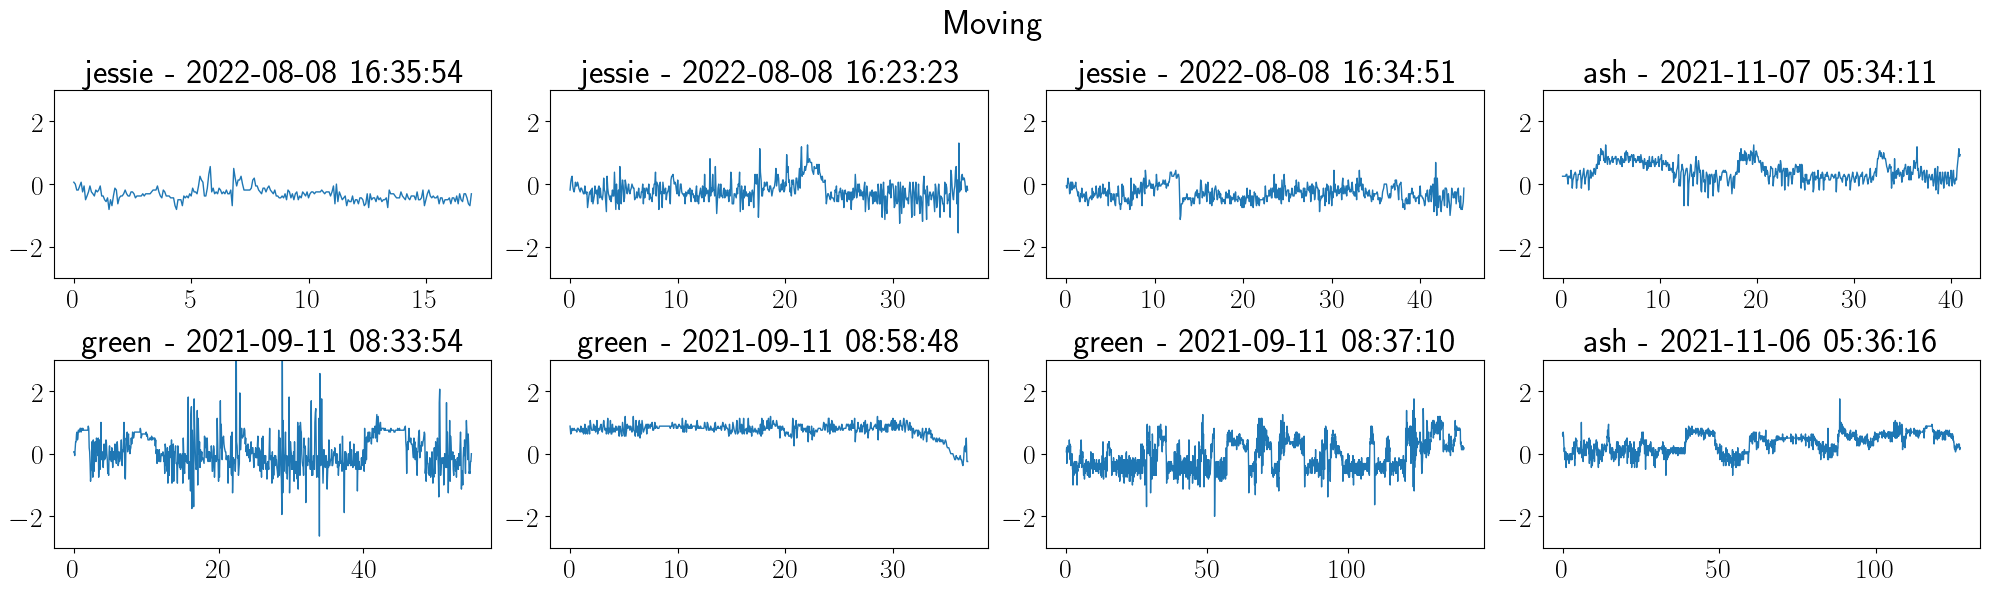

In [85]:
moving_data = acc_data[acc_data['behavior'] == 'Eating'].reset_index(drop=True)
idx = np.random.choice(range(0, len(moving_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(moving_data.iloc[idx[i]]['acc_x']))/16, moving_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = moving_data.iloc[idx[i]]['dog ID'], pd.to_datetime(moving_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Moving', fontsize=25)
plt.tight_layout()
plt.show()


#### Vigilant

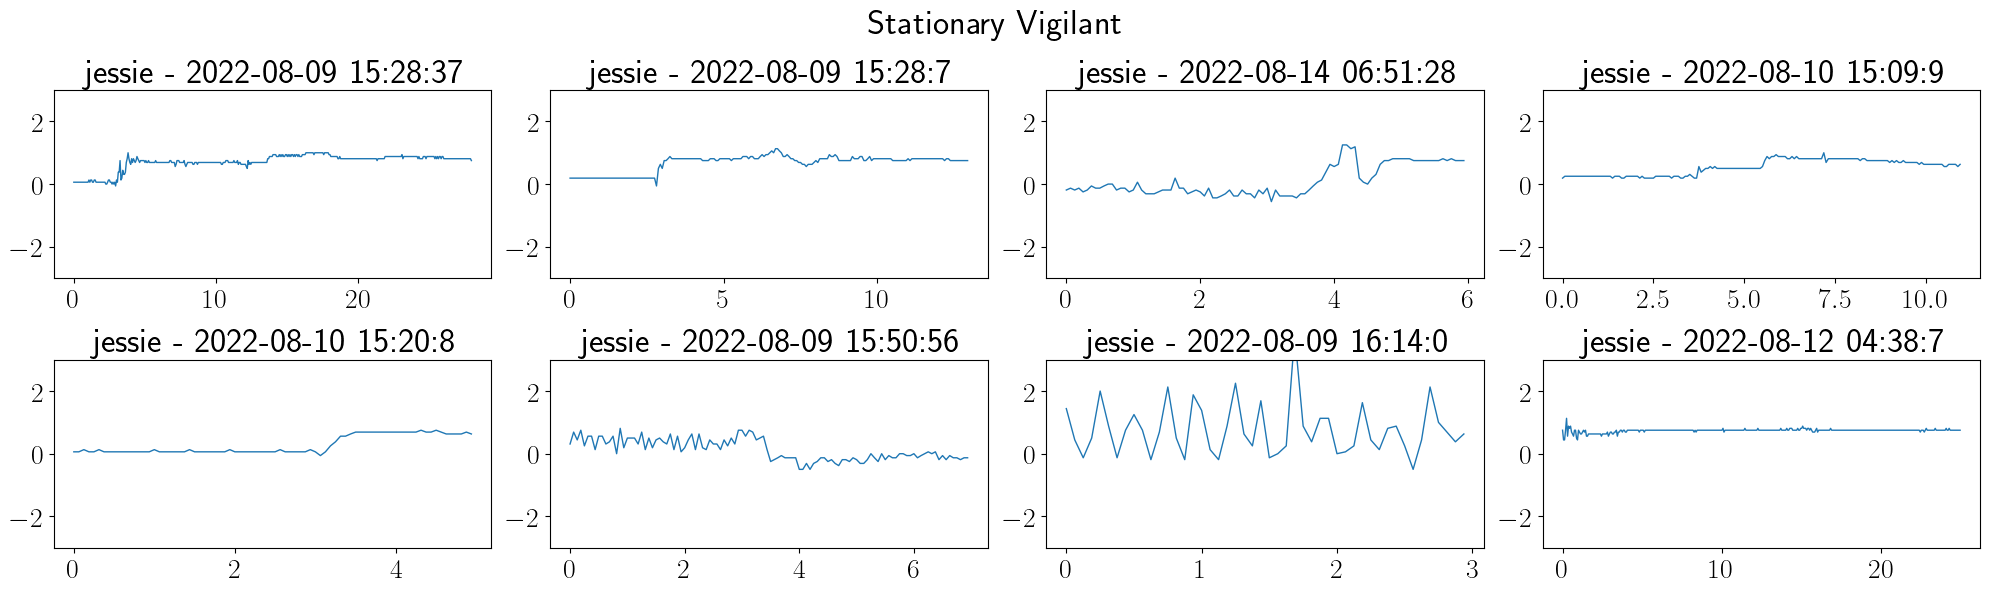

In [86]:
stationary_data = acc_data[acc_data['behavior'] == 'Stationary vigilant'].reset_index(drop=True)
idx = np.random.choice(range(0, len(moving_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(stationary_data.iloc[idx[i]]['acc_x']))/16, stationary_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = stationary_data.iloc[idx[i]]['dog ID'], pd.to_datetime(stationary_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Stationary Vigilant', fontsize=25)
plt.tight_layout()
plt.show()


#### Resting

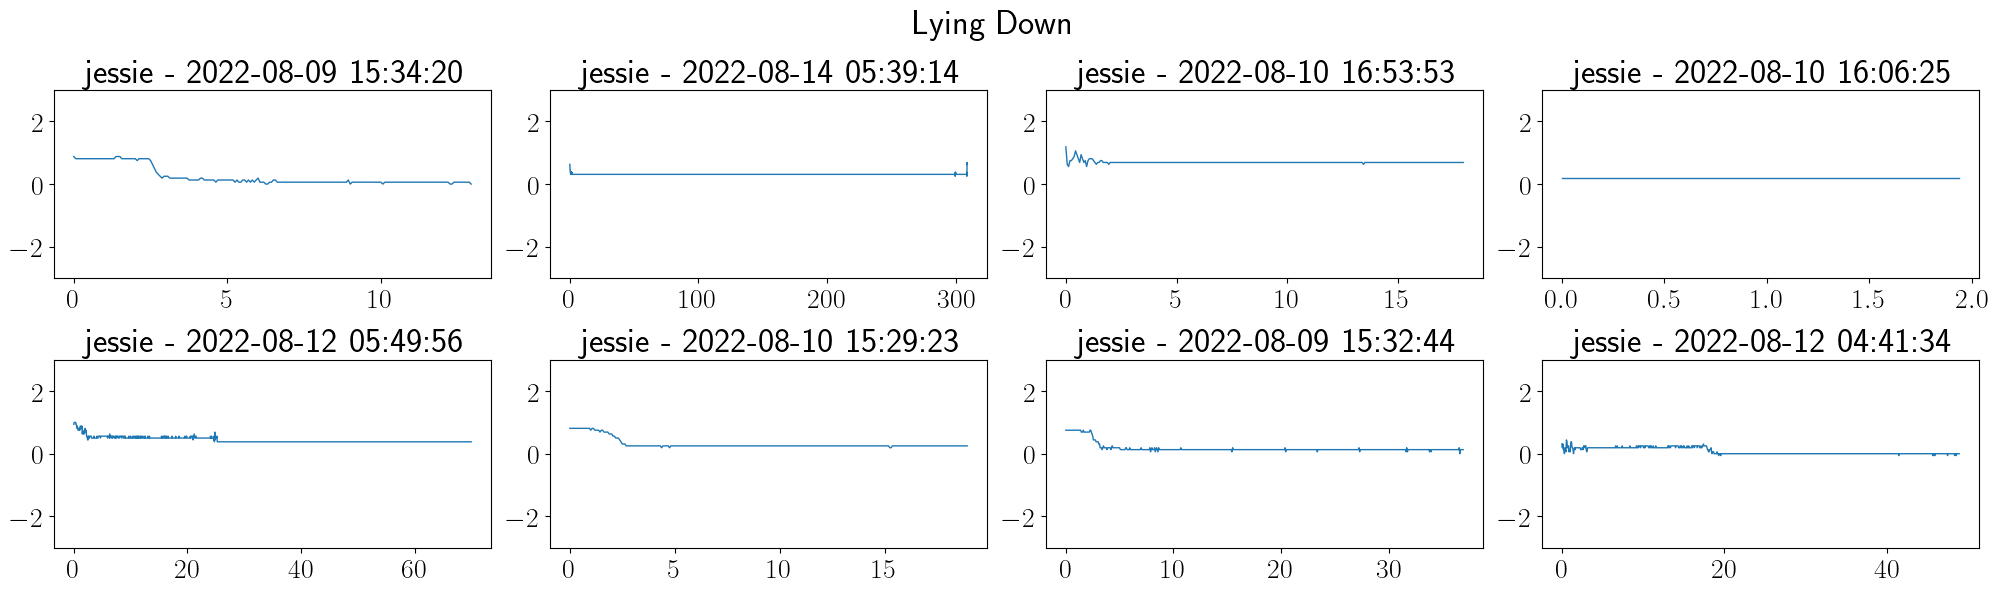

In [87]:
lying_data = acc_data[acc_data['behavior'] == 'Lying down'].reset_index(drop=True)
idx = np.random.choice(range(0, len(moving_data)), 8, replace=False)

fig, axs = plt.subplots(2, 4, figsize=(20,6))
for i in range(8):
    axs[i//4, i%4].plot(np.arange(len(lying_data.iloc[idx[i]]['acc_x']))/16, lying_data.iloc[idx[i]]['acc_x'])
    axs[i//4, i%4].set_ylim(-3,3)
    dog, dog_time = lying_data.iloc[idx[i]]['dog ID'], pd.to_datetime(lying_data.iloc[idx[i]]['behavior_start'])
    hour, minute, sec = dog_time.hour, dog_time.minute, dog_time.second
    axs[i//4,i%4].set_title(f'{dog} - {dog_time.date()} {hour:02}:{minute:02}:{sec:00}')
fig.suptitle('Lying Down', fontsize=25)
plt.tight_layout()
plt.show()
